# Malaria Blood Smear Analyzer

## Inspect blood smear images

In [ ]:
# Import modules
import imageio
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import numpy as np
from skimage.morphology import watershed
from skimage.feature import peak_local_max

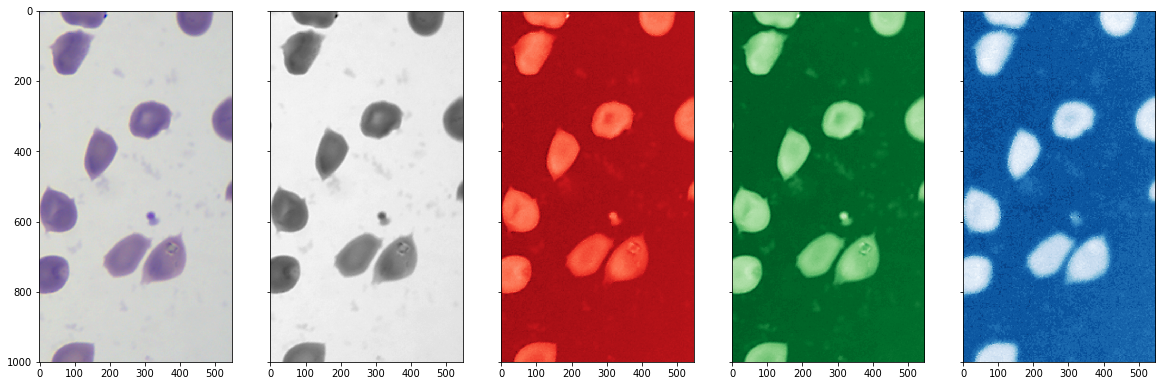

In [378]:
#Get channels and convert to grayscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

im = imageio.imread("ko_2#3.bmp")
im = im[500:1500, 1500:2500]
im_r = im[:, : , 0]
im_g = im[:, :, 1]
im_b = im[:, :, 2]
im_gray = rgb2gray(im)

fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(20, 25))
axes[0].imshow(im)
axes[1].imshow(im_gray, cmap="gray")
axes[2].imshow(im_r, cmap="Reds")
axes[3].imshow(im_g, cmap="Greens")
axes[4].imshow(im_b, cmap="Blues")


plt.show()

In [379]:
#Calculate histograms for each channel as well as the grayscale image
hist_r = ndi.histogram(im_r, min=0, max=255, bins=256)
hist_g = ndi.histogram(im_g, min=0, max=255, bins=256)
hist_b = ndi.histogram(im_b, min=0, max=255, bins=256)
hist = ndi.histogram(im_gray, min=0, max=255, bins=256)

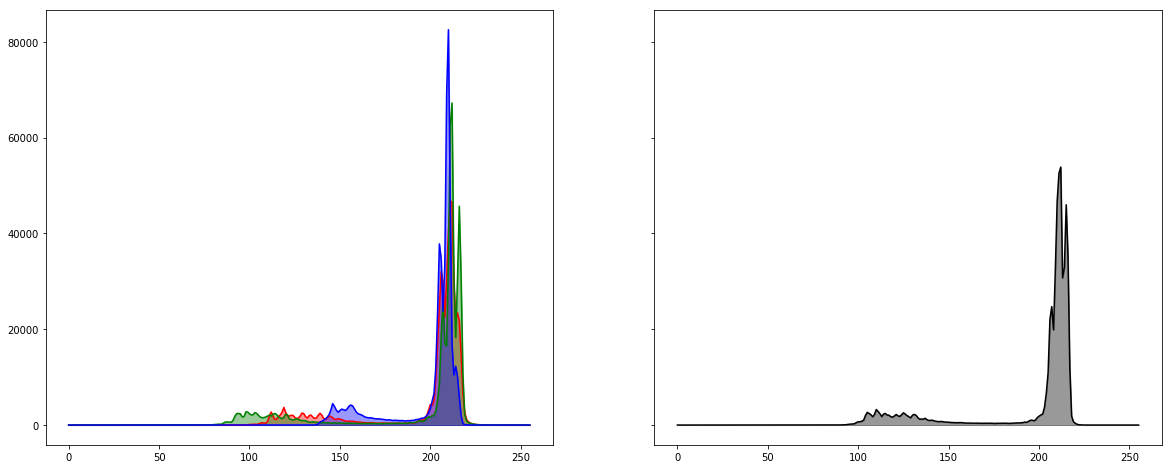

In [380]:
#Plot histograms
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 8))
x = np.arange(0,256)
axes[0].plot(hist_r, c='r')
axes[0].fill_between(x, hist_r, color='red', alpha=0.4)
axes[0].plot(hist_g, c='g')
axes[0].fill_between(x, hist_g, color='green', alpha=0.4)
axes[0].plot(hist_b, c='b')
axes[0].fill_between(x, hist_b, color='blue', alpha=0.4)

axes[1].plot(hist, c='k')
axes[1].fill_between(x, hist, color='black', alpha=0.4)
plt.show()

It seems that the RBC intensities are between 60 and 180 in each channel. This may be different from image to image due to different illumination. In the following, I only use these threshold values for this specific image for masking. A more robust solution will be necessary later.

22 32 32


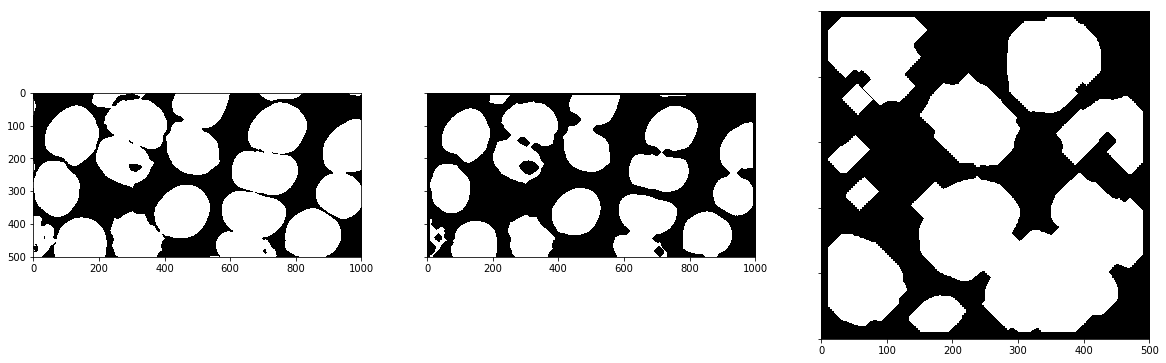

In [323]:
# Masking out the Red blood cells
# Largest contrast in the green channel
filt=ndi.gaussian_filter(im_g, 
                         sigma=2)
mask_rbc =  (filt > 150) & (filt < 200)
mask_rbc_erode = ndi.binary_erosion(mask_rbc, iterations=10)                 # Erode mask to separate cells 
mask_rbc_closing = ndi.binary_closing(mask_rbc_erode, iterations=10)         # Close inner holes 

# Plot masked images
fig, axes = plt.subplots(1,3, sharey=True, figsize=(20, 25))
axes[0].imshow(mask_rbc, cmap="gray")
axes[1].imshow(mask_rbc_erode, cmap="gray")
axes[2].imshow(mask_rbc_open, cmap="gray")

labels1, nlabels1 = ndi.label(mask_rbc)
labels2, nlabels2 = ndi.label(mask_rbc_erode)
labels3, nlabels3 = ndi.label(mask_rbc_closing)
print(nlabels1, nlabels2, nlabels3)

## Optimize mask

0
255


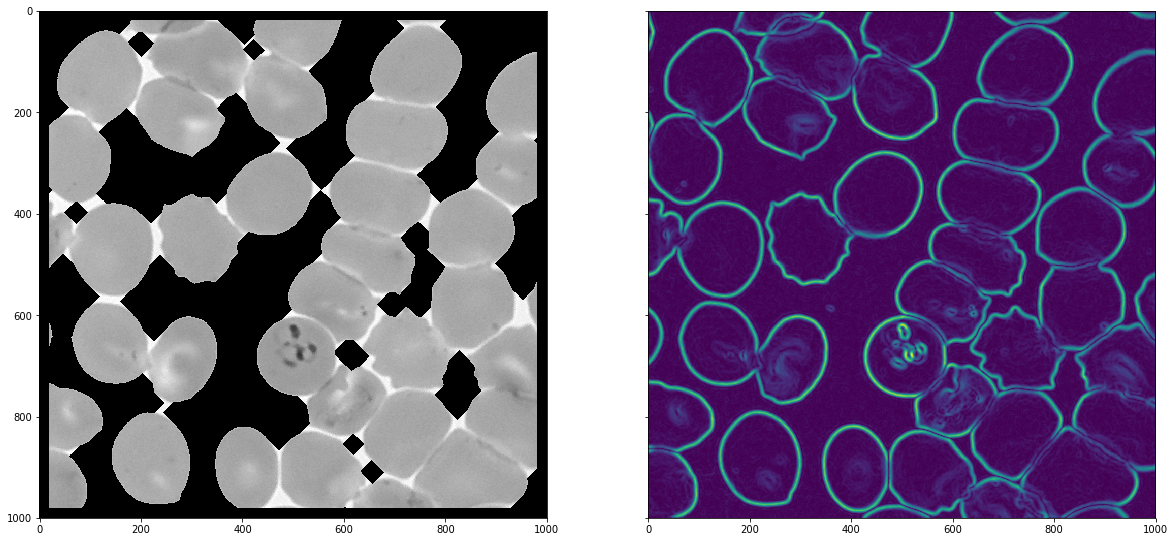

In [324]:
# Closing holes first
mask_rbc_close = ndi.binary_closing(mask_rbc, iterations=20)

# Detect edges
sobel_ax0 = ndi.sobel(ndi.gaussian_filter(im_gray, 
                         sigma=2), axis=0)
sobel_ax1 = ndi.sobel(ndi.gaussian_filter(im_gray, 
                         sigma=2), axis=1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0)+np.square(sobel_ax1))
edges = (edges/edges.max()*255).astype(np.uint8)
print(edges.min())
print(edges.max())
# Plot edge magnitude
fig, axes = plt.subplots(1,2, sharey=True, figsize=(20, 25))
axes[0].imshow(np.where(mask_rbc_close, im_g, 0), cmap="gray")
axes[1].imshow(edges, cmap="viridis", vmax=256)
plt.show()

## RBC segmentation with Watershed algorithm

In the following, I start over the masking procedure from the beginning for in-situ optimization. This is still not robust, and needs to be adjusted for each image.

RBC count:  37


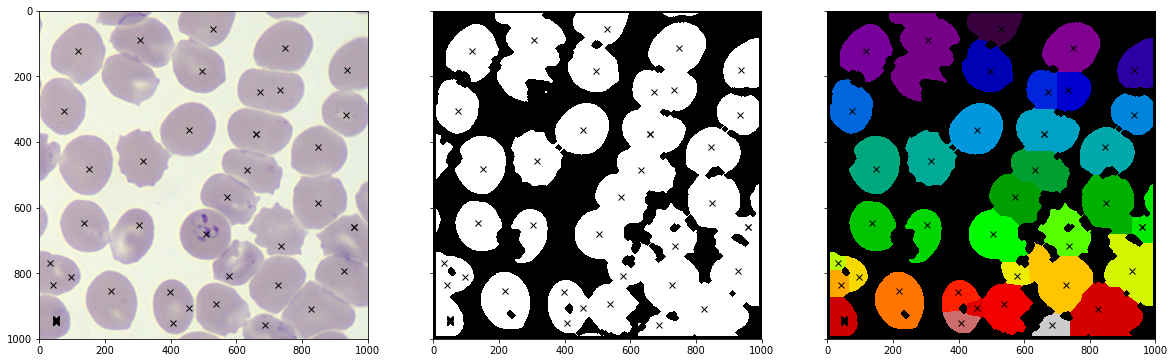

In [382]:
# Reading image and separate channels
im = imageio.imread("ko_1_#3.bmp")
im = im[500:1500, 1500:2500]
im_r = im[:, : , 0]
im_g = im[:, :, 1]
im_b = im[:, :, 2]
im_gray = rgb2gray(im)

# Masking by trial-and-error
filt=ndi.gaussian_filter(im_g, 
                         sigma=2)
mask_rbc =  (filt > 80) & (filt < 180)
mask = mask_rbc
mask = ndi.binary_closing(mask, iterations=10)
# mask = ndi.binary_erosion(mask, iterations=5)
# mask = ndi.gaussian_filter(mask, sigma=2)
# mask = ndi.binary_dilation(mask, iterations=10)
# ndi.binary_dilation(ndi.binary_closing(ndi.binary_erosion(mask_rbc, iterations=20), iterations=25), iterations=20)

# Distance transformation for obtaining markers
distance = ndi.distance_transform_edt(mask)
local_maxi = peak_local_max(distance, indices=False, min_distance = 30,
                            labels=mask)


markers, nlabels = ndi.label(local_maxi, structure=np.ones((3,3)))
print("RBC count: ", nlabels)
labels = watershed(-distance, markers, mask=mask)

x, y = np.where(local_maxi)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20,15))
axes[0].imshow(im)
axes[0].plot(y, x, 'kx')
axes[1].imshow(mask, cmap="gray", interpolation='nearest')
axes[1].plot(y, x, 'kx')
axes[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
axes[2].plot(y, x, 'kx')

plt.show()

12405

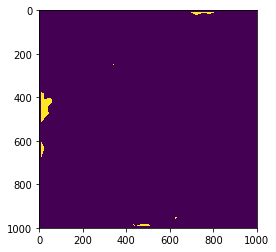

In [399]:
plt.imshow(np.where(labels==0, mask, 0))
mask[labels==1].size